In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, forecast_by_week, train_test_split, evaluate_R_forecasts, process_R_results
from PythonFiles.PlottingFunctions import plot_coverage, print_forecasts_by_week, hyperparameter_boxplots, plot_model_results_by_hp,\
hp_color_plot, plot_forecast_entry
from PythonFiles.Configuration import Configuration
from PythonFiles.HpTuning import get_data, objectiveFNN
from datetime import datetime
import mxnet as mx
from PythonFiles.OverwrittenEvaluator import Evaluator, strict_coverage
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions#, Evaluator
from gluonts.mx.model.simple_feedforward import SimpleFeedForwardEstimator
mx.random.seed(0)
np.random.seed(0)
selected_regions = ['SK Delmenhorst','LK Olpe', 'SK Landau i.d.Pfalz','LK Kaiserslautern','SK Karlsruhe', 'SK Leipzig','SK Hamburg', 'SK München']
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')

data_splits_dict, base_df = get_data(truncate=False, with_features=True)
locations = list(influenza_df.location.unique())
train = data_splits_dict["with_features_2001"][0]
test = data_splits_dict["with_features_2001"][1]
config = Configuration()

In [2]:
results_dict = np.load('/home/reffert/DeepAR_InfluenzaForecast/ignore_this_directory/default_models.npy',allow_pickle='TRUE').item()
forecasts_dict, evaluator_df_dict = forecast_by_week(config, train, test, locations, models_dict = {"DeepAR":None, "FNN":None}, seed=0, results_dict=results_dict)

Running evaluation: 411it [00:09, 42.75it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:09, 41.73it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:09, 44.42it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:09, 43.77it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:13, 31.14it/s]
/ho

In [3]:
results_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/results.csv", sep=',')
processed_df = process_R_results(config, results_df, influenza_df)
df_dict = {"hhh4":{1:processed_df[processed_df.WeekAhead == 1].copy(),
           2:processed_df[processed_df.WeekAhead == 2].copy(),
           3:processed_df[processed_df.WeekAhead == 3].copy(),
           4:processed_df[processed_df.WeekAhead == 4].copy()}}
# print_forecasts_by_week(config, base_df, df_dict, selected_regions[:], [1,2,3,4], plot_begin_at_trainstart=datetime(2016,1,1,0,0,0))
evaluator_df = evaluate_R_forecasts(config, df_dict["hhh4"], locations, processed_df)

Evaluating 1/4 -- 2023-05-25 13:29:11.090323
Evaluating 2/4 -- 2023-05-25 13:31:17.464779
Evaluating 3/4 -- 2023-05-25 13:33:32.902991
Evaluating 4/4 -- 2023-05-25 13:35:16.897062


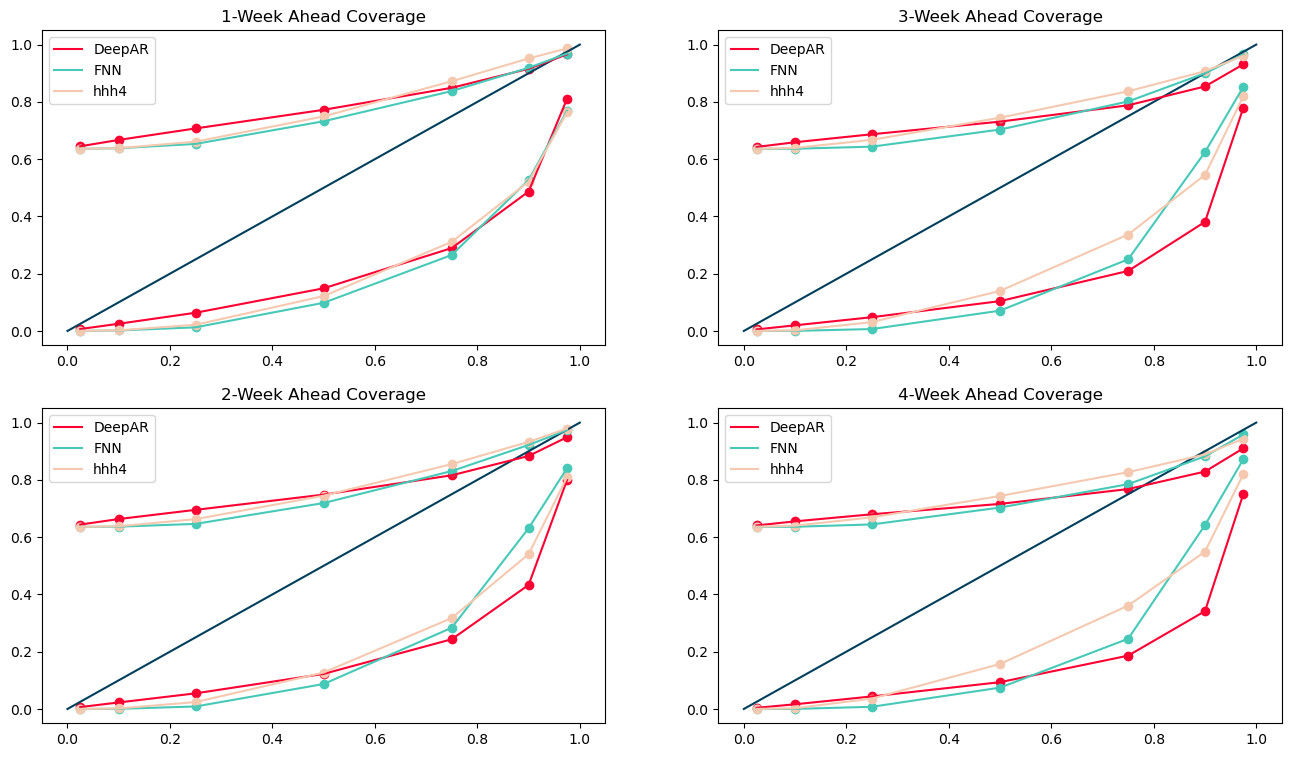

In [24]:
evaluator_df_dict["hhh4"] = evaluator_df
colors = config.colors[:3]+config.colors[12:]
plot_coverage(config, evaluator_df_dict, colors=colors, strict=True)
os.chdir('/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation')
plt.savefig(f"CoveragePlot.png")
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
#for key in evaluator_df_dict.keys():
#    print(key)
#   print(evaluator_df_dict[key].loc[evaluator_df_dict[key]["mean_WIS"]>0, ["item_id","mean_WIS"]])

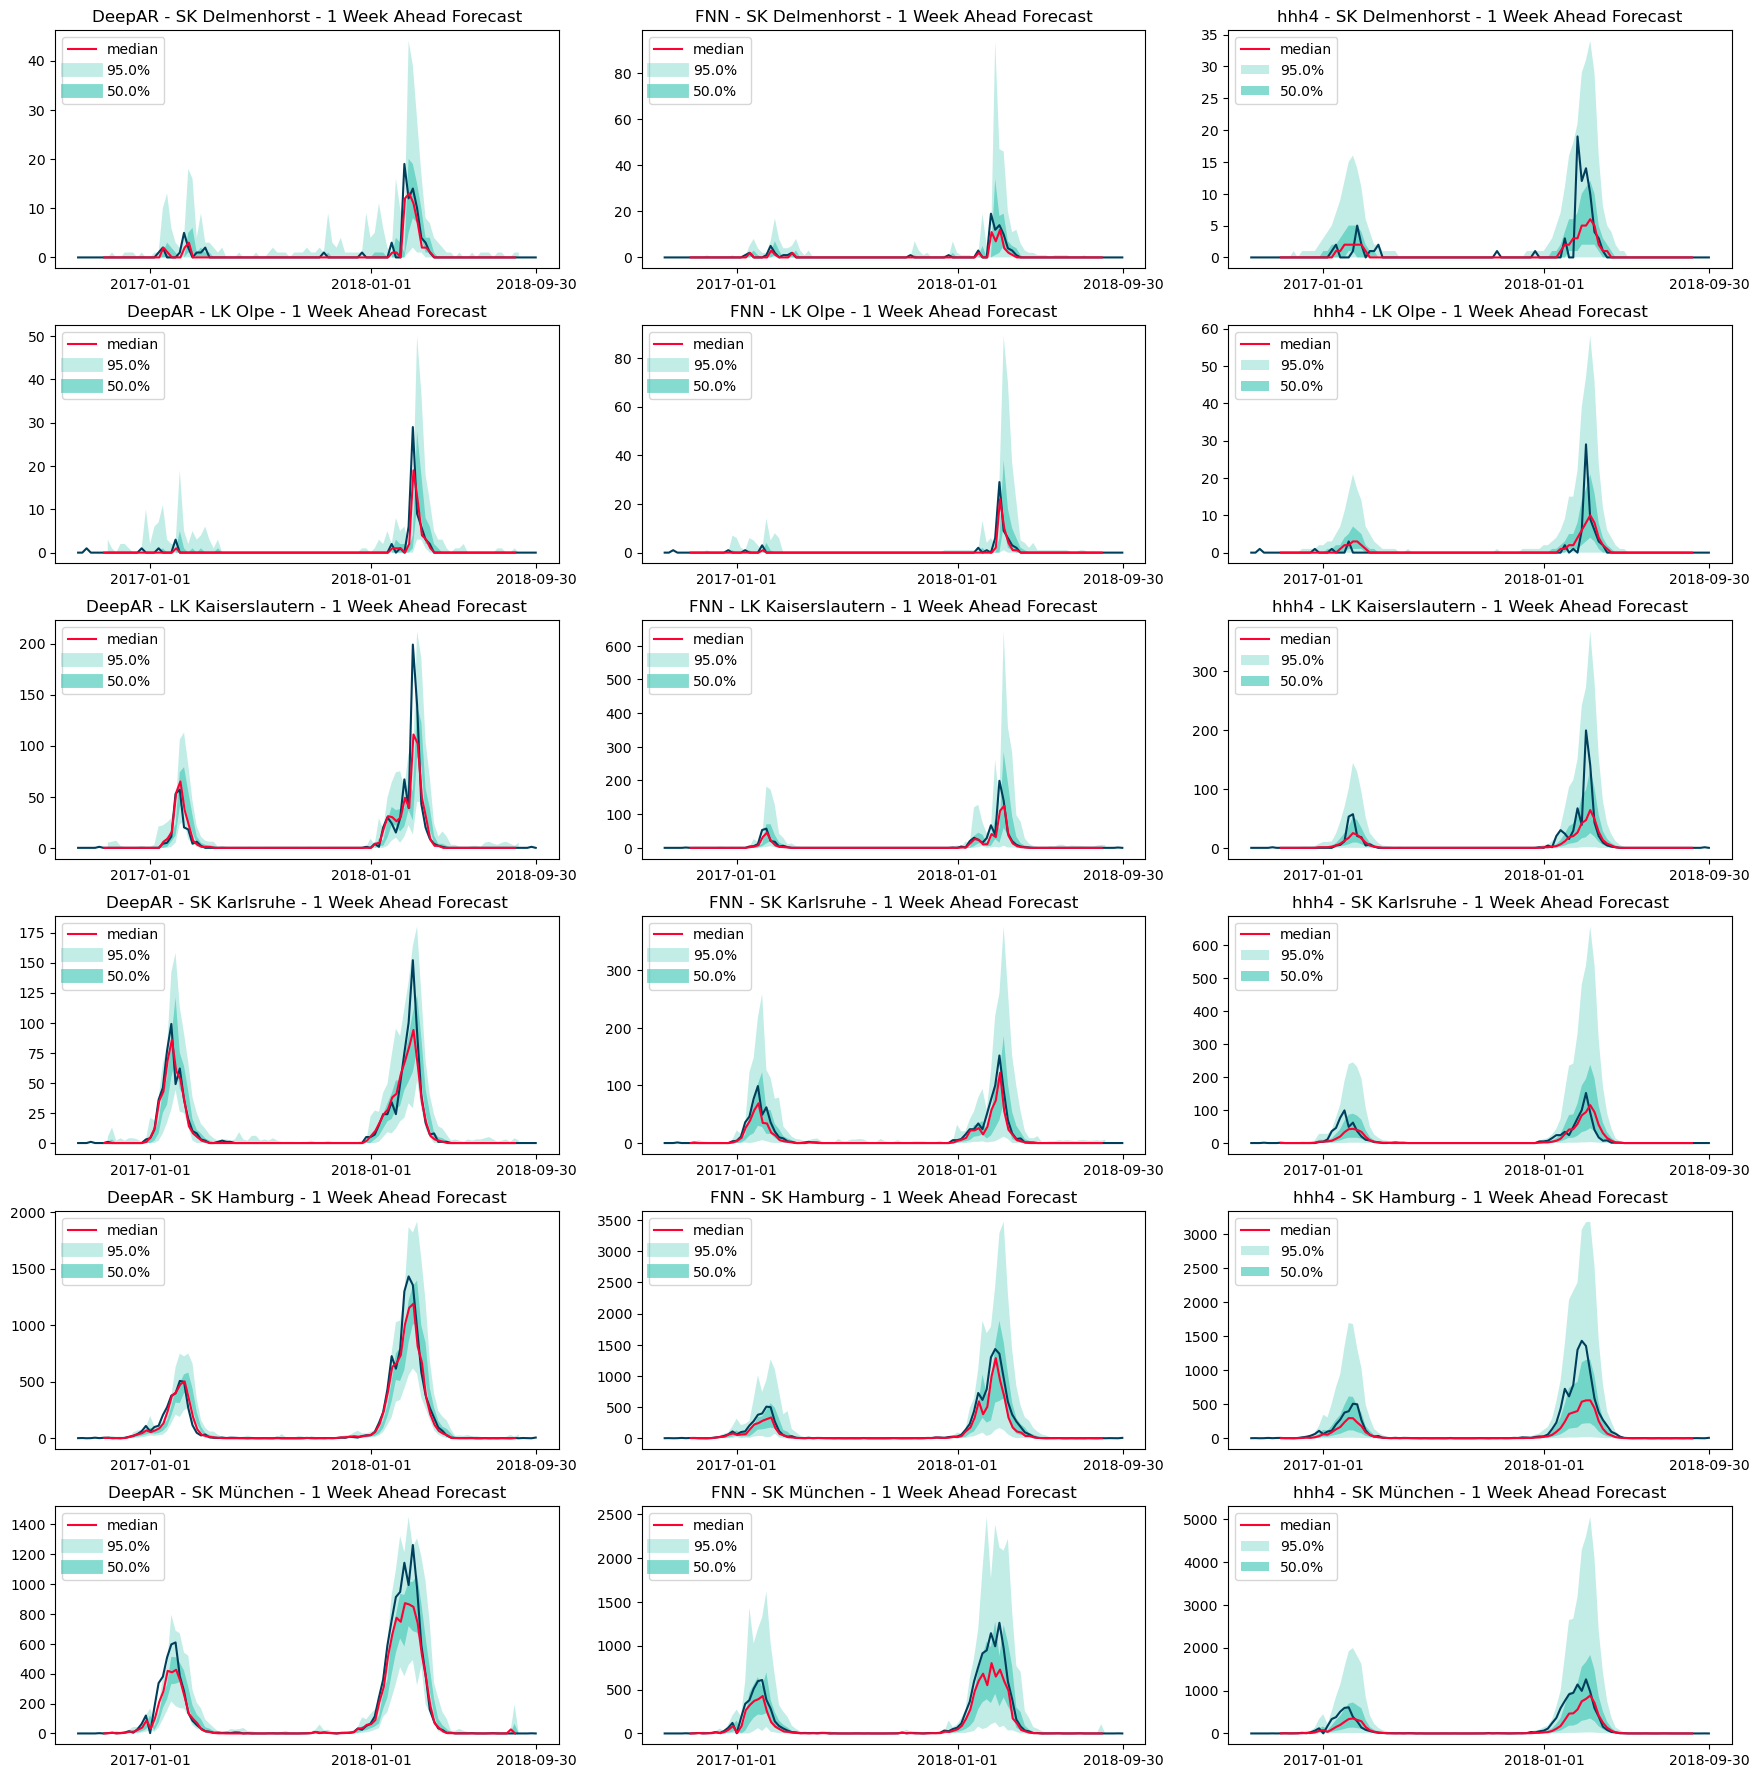

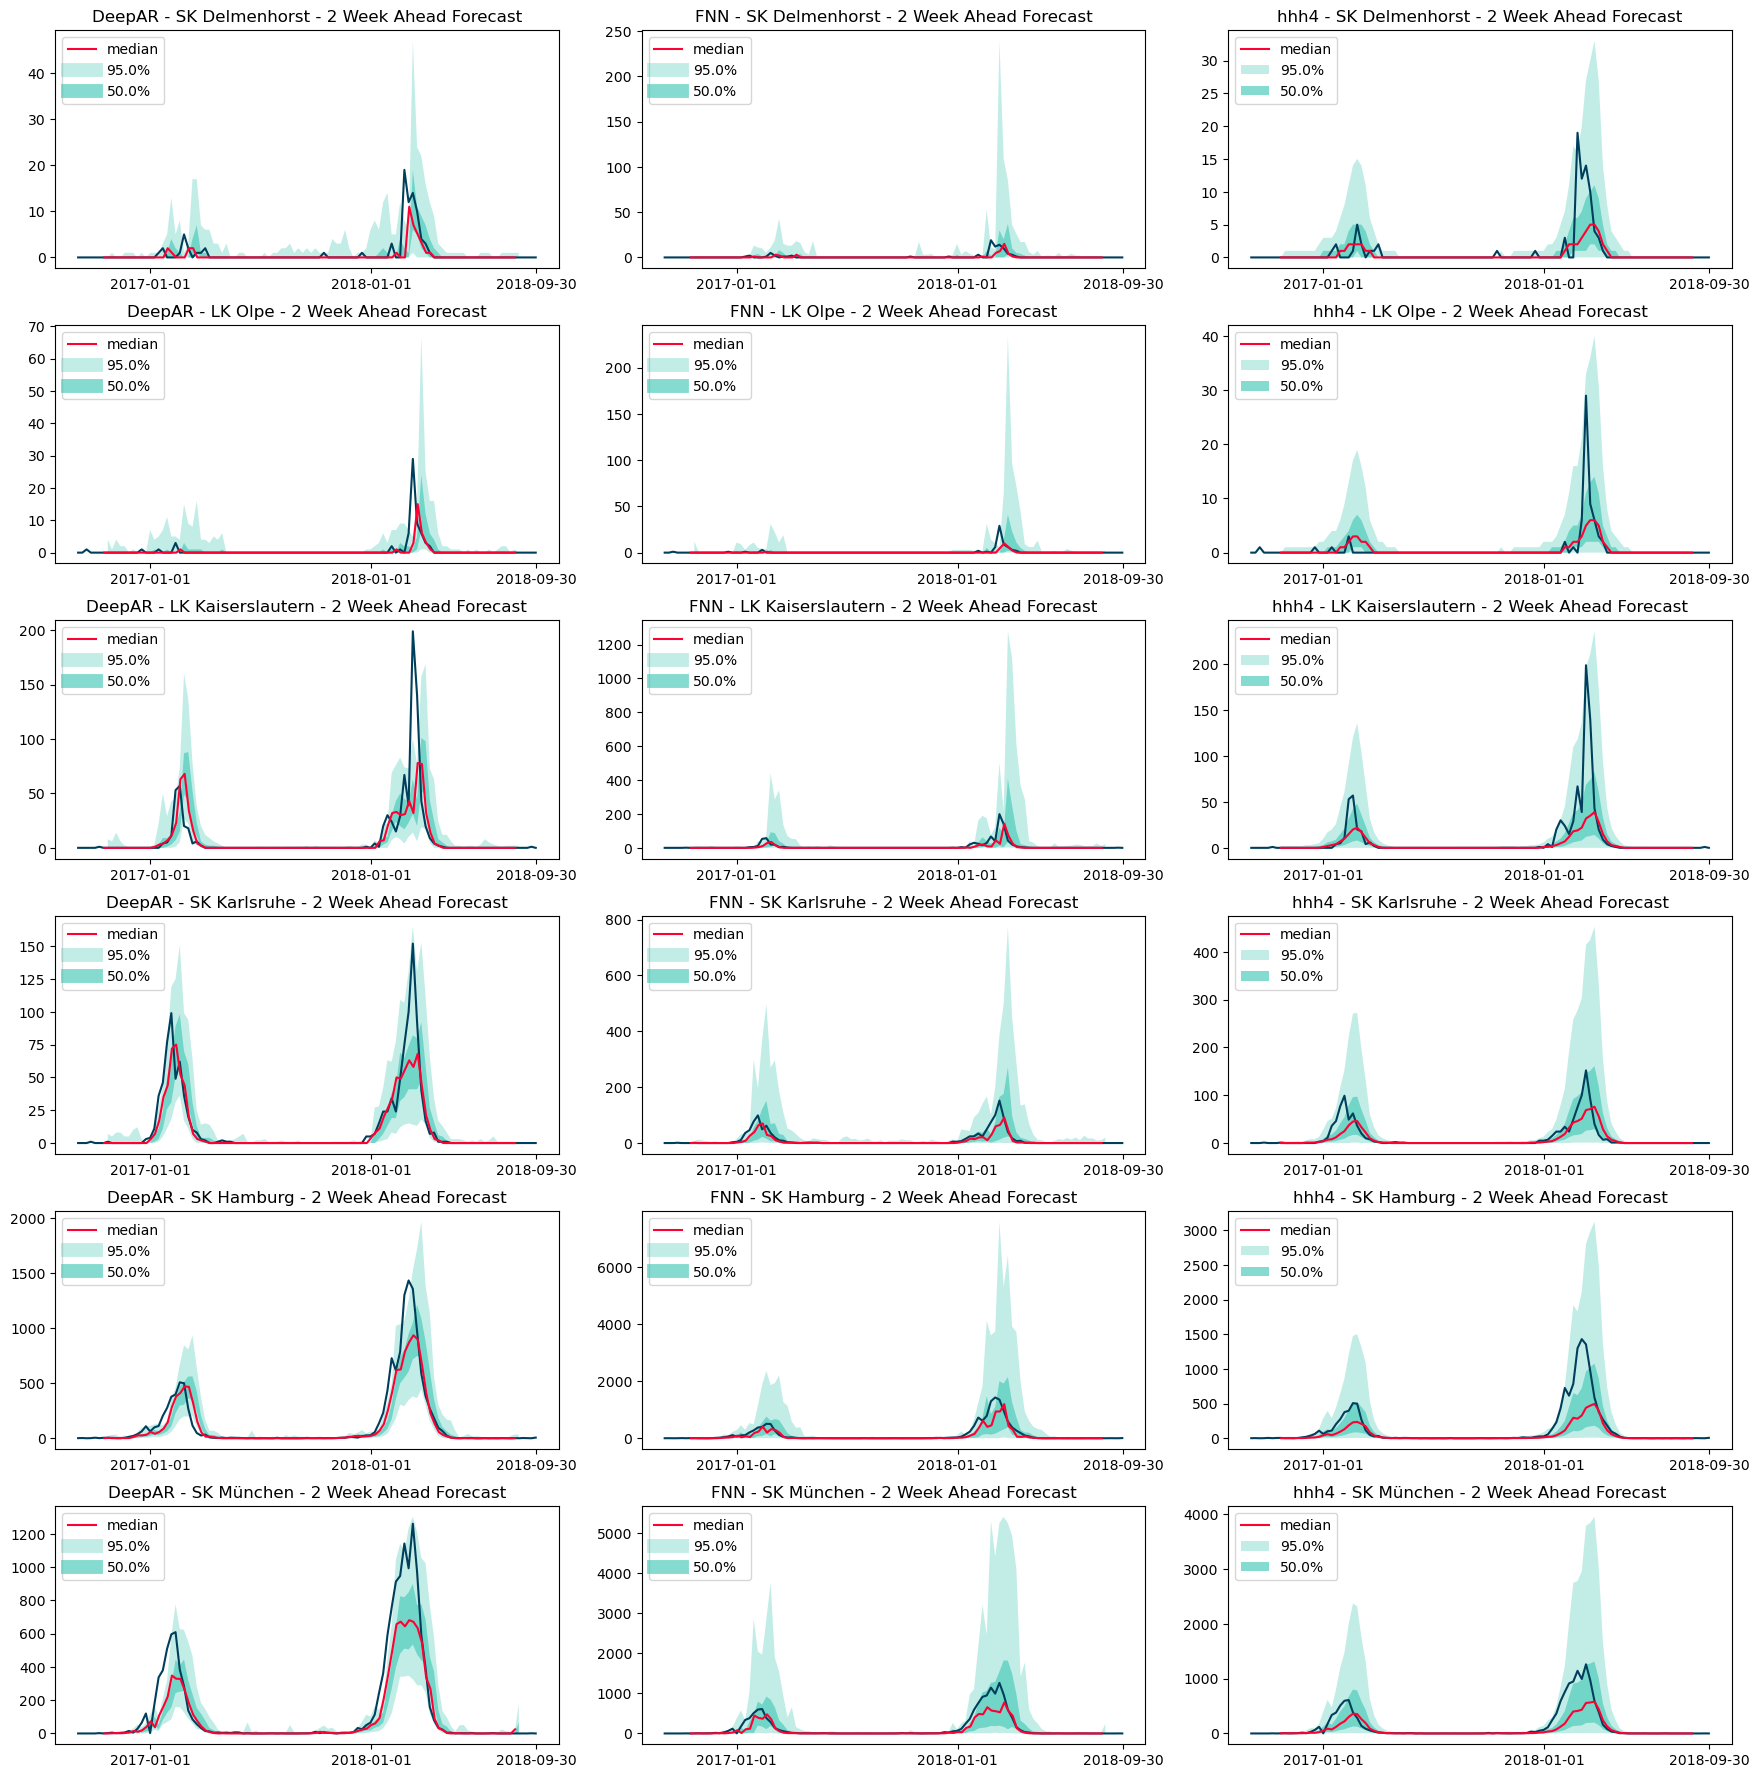

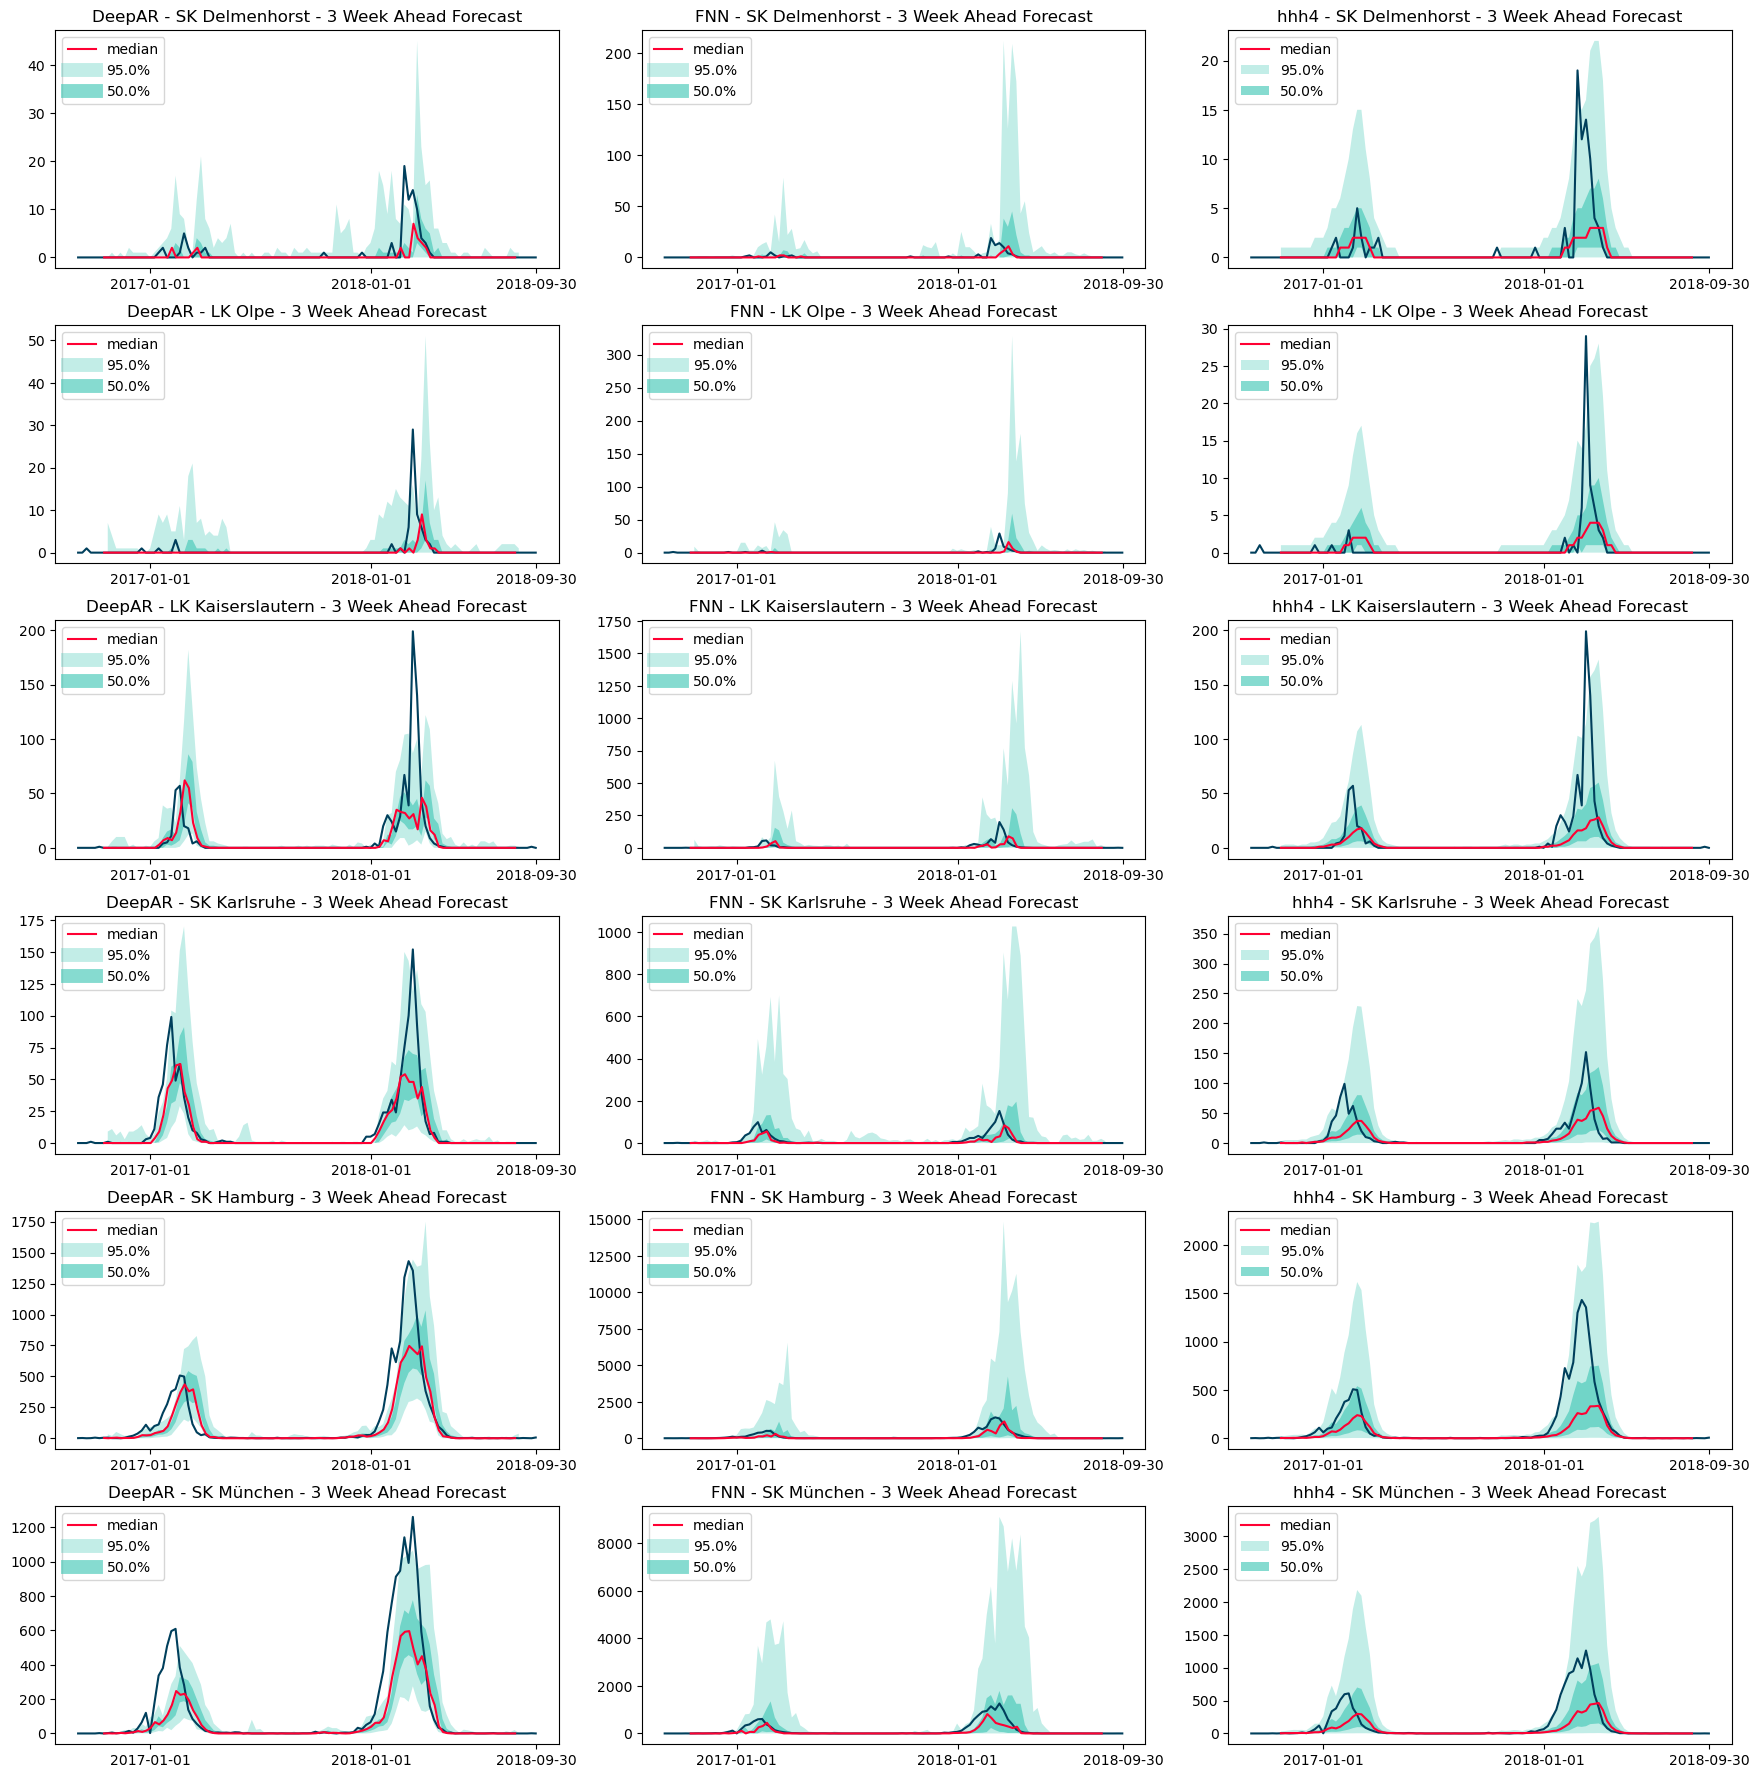

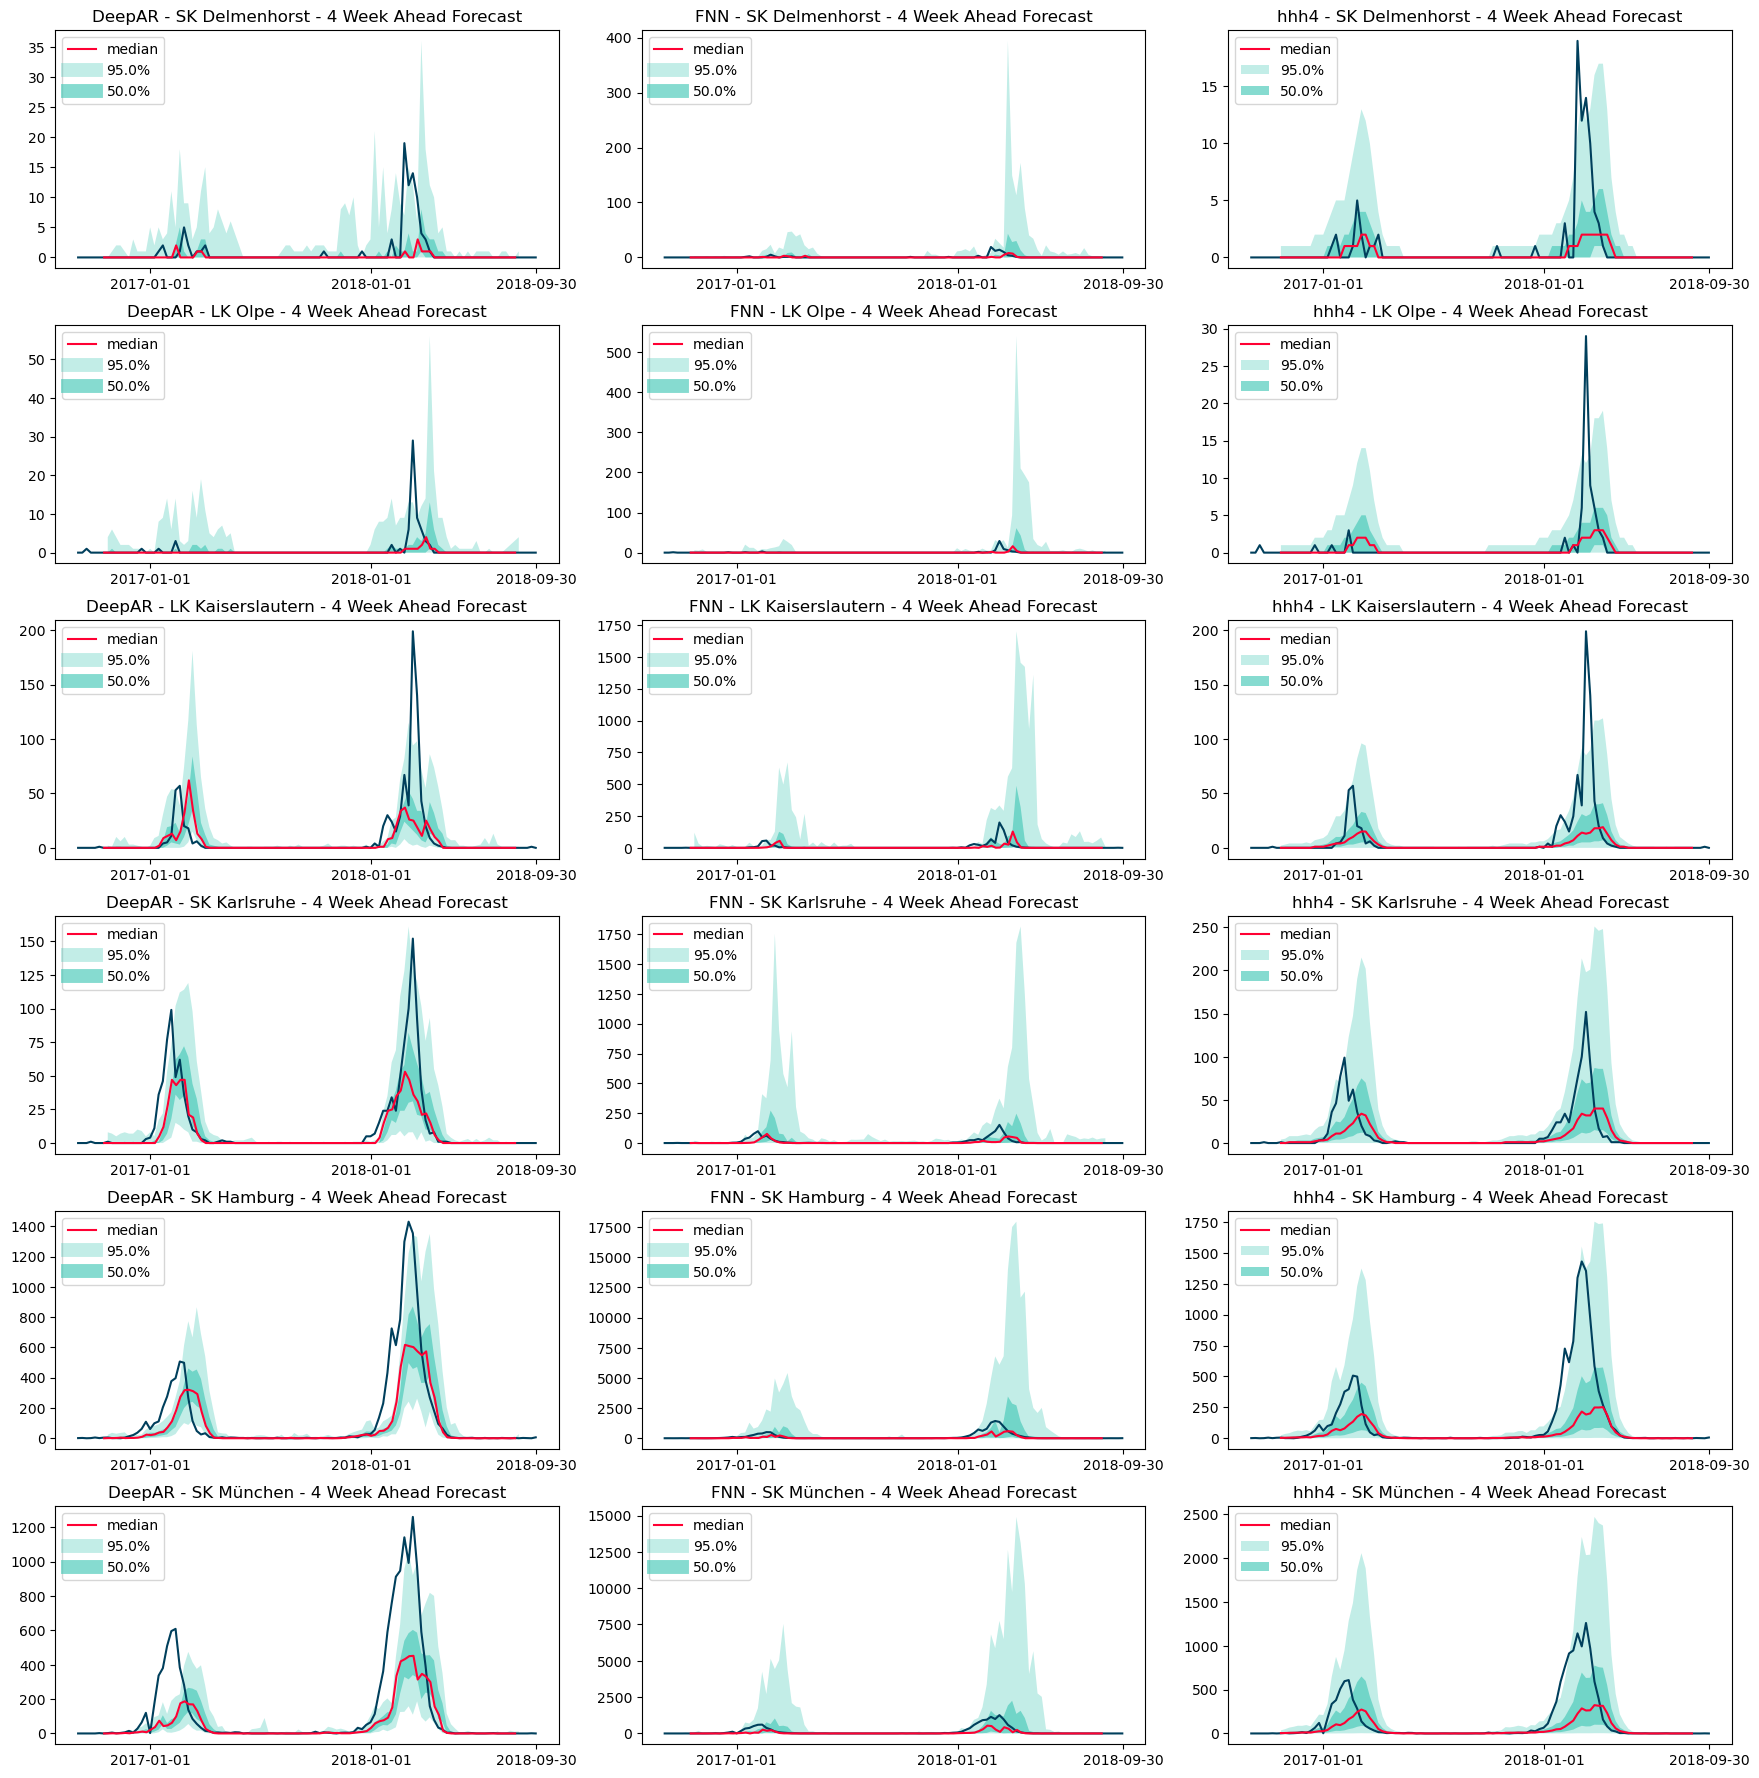

In [23]:
def print_forecasts_by_week1(config, df, forecasts_dict, locations, week_ahead_list, plot_begin_at_trainstart=False, savepath=None, filename=None, figsize=(25, 20)):
    '''
    @Overwritten 
    Prints out plots for the given week-Ahead forecasts of given locations. It needs the initial corrected dataframe, as well as the forecast_dict
    that contains the different week-ahead forecasts.
    The start of the plot time axis, can be set to the training start time (TRUE) or the testing start time (FALSE).
    '''
    if (savepath != None)&(filename!=None):
        import os
    all_locations=list(df.location.unique())
    for week_ahead in week_ahead_list:
        fig, ax = plt.subplots(len(locations), 3, figsize=figsize)
        fig.tight_layout(pad=2.9)
        for location in locations:
            for key in list(forecasts_dict.keys()):
                row = locations.index(location)
                column = list(forecasts_dict.keys()).index(key)
                plotnumber = [row, column]
                plt.sca(ax[tuple(plotnumber)])
                plt.xticks(rotation=0)
                plt.title(f'{key} - {location} - {week_ahead} Week Ahead Forecast')
                
                if plot_begin_at_trainstart == True:
                    plot_start_time = config.train_start_time
                elif type(plot_begin_at_trainstart)==type(datetime(2016,1,1,1,1,1)):
                    plot_start_time = plot_begin_at_trainstart
                else:
                    plot_start_time = config.train_end_time
                    
                #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
                plt.plot((df.loc[(df['location'] == location) &
                                        (df.index <= config.test_end_time) &
                                        (df.index >= plot_start_time)].index),
                         df.loc[(df['location'] == location) &
                                       (df.index <= config.test_end_time) &
                                       (df.index >= plot_start_time),'value'], c=config.colors[0])
                #ax[tuple(plotnumber)].grid(which="both")
                # run the overwritten version of the forecast_entry.plot() function to plot to a specific axis and change colors
                forecast_dict = forecasts_dict[key] 
                if key == "hhh4":
                    # Here forecast_entry is a df
                    forecast_entry = forecast_dict[list(forecast_dict.keys())[week_ahead-1]].copy()
                    plot_forecast_entry(config, forecast_entry.loc[forecast_entry["location"]==location], show_mean=False, ax=ax[tuple(plotnumber)], mediancolor=config.colors[1], fillcolor=config.colors[2], axis=True,\
                                        prediction_intervals=(50.0, 95.0), R_entry=True)
                else:
                    # select the right week-ahead forecast entry for a set location
                    forecast_entry = forecast_dict[list(forecast_dict.keys())[week_ahead-1]][all_locations.index(location)]
                    plot_forecast_entry(config, forecast_entry, show_mean=False,ax=ax[tuple(plotnumber)], mediancolor=config.colors[1],fillcolor=config.colors[2], axis=True, prediction_intervals=(50.0, 95.0))
                    #forecast_entry.plot(prediction_intervals=prediction_intervals, color=config.colors[0])
                plt.xticks([datetime(2017,1,1), datetime(2018,1,1), config.test_end_time], rotation=0, ha="center")
                plt.legend(loc="upper left")
        if (savepath != None)&(filename!=None):
            os.chdir(savepath)
            plt.savefig(f"{filename}Combined_{week_ahead}_WA.png")
            os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
        plt.show()
            
forecasts_dict["hhh4"] = {1:processed_df[processed_df.WeekAhead == 1].copy(),
                          2:processed_df[processed_df.WeekAhead == 2].copy(),
                          3:processed_df[processed_df.WeekAhead == 3].copy(),
                          4:processed_df[processed_df.WeekAhead == 4].copy()}
new_regions = ['SK Delmenhorst','LK Olpe','LK Kaiserslautern','SK Karlsruhe', 'SK Hamburg', 'SK München']
#print_forecasts_by_week1(config, base_df, df_dict, selected_regions[:], [1,2,3,4], plot_begin_at_trainstart=datetime(2016,1,1,0,0,0))
print_forecasts_by_week1(config, base_df, forecasts_dict, new_regions, [1, 2, 3, 4], plot_begin_at_trainstart=datetime(2016,9,1,0,0,0),
                        savepath='/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation/png_files', filename="Default", figsize=(18, 22))          

In [ ]:
coverage_cols = [col for col in evaluator_df_dict[list(evaluator_df_dict.keys())[0]].columns if "Coverage" in col]
#quantile_cols = [col for col in evaluator_df_dict[list(evaluator_df_dict.keys())[0]].columns if "QuantileLoss" in col]
quantile_cols = [f"QuantileLoss[{quantile}]" for quantile in config.quantiles]
selected_regions = [f"{location} "+"{"+ f"{week_ahead}"+"}" for location in locations for week_ahead in [1]]#, 2, 3, 4]]
#np.array([df[f"QuantileLoss[{quantile}]"] for quantile in config.quantiles]).mean()
for key in evaluator_df_dict.keys():
    print(key)
    selected_df = evaluator_df_dict[key].loc[evaluator_df_dict[key]["item_id"].isin(selected_regions),:]
    aggregated_df = evaluator_df_dict[key].loc[evaluator_df_dict[key]["item_id"].isin([i for i in evaluator_df_dict[key]["item_id"] if "aggregated" in i]),:]
    print(aggregated_df[["item_id"] + coverage_cols])
    selected_df["individual_WIS"] = selected_df[quantile_cols].mean(axis=1)
    #print(selected_df[["item_id", "individual_WIS"]])
    #print(selected_df[["item_id"]+[col for col in evaluator_df_dict[list(evaluator_df_dict.keys())[0]].columns if "QuantileLoss" in col]])
    #print(selected_df["individual_WIS"].mean()) # is equal to the WIS score of aggregated {1}
